In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.ticker import MaxNLocator
import matplotlib
import matplotlib.colors as colors
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.sans-serif'] = "Arial" # missing fonts:: https://alexanderlabwhoi.github.io/post/2021-03-missingfont/
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams.update({'font.size': 14, 'axes.linewidth': 2, 'xtick.major.width': 1.5, 'xtick.major.size': 4, 'ytick.major.width': 1.5, 'ytick.major.size': 4})
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
def save_pdf(save_file, fig):
    pdf = PdfPages(save_file)
    pdf.savefig(fig, bbox_inches='tight')
    pdf.close()
    return

In [3]:
selected_variants_file = "../data/variably_expressive/gene_variants.csv"

In [4]:
df = pd.read_csv(selected_variants_file, dtype=str)

In [5]:
def get_variant_loc_obesity_info(df):
    pivot_df = df.pivot_table(index="variant_id", values=["SYMBOL", "Mut_type", "obesity_type", "Sample"], aggfunc=lambda x: ",".join(np.unique(x)))
    pivot_df["obesity_ntypes"] = pivot_df.obesity_type.map(lambda x: len(x.split(",")))
    return pivot_df

In [6]:
vloc_df = get_variant_loc_obesity_info(df)

In [7]:
def create_mut_loc_table_helper(df, name):
    df = df.reset_index().pivot_table(index="SYMBOL", values=["variant_id", "Sample"], aggfunc={
    "variant_id": lambda x: len(set(x)),
    "Sample": lambda x: len(set(sum([i.split(",") for i in x], [])))})
    df = df.reset_index()
    df["obesity_type"] =  name
    return df.loc[:, ["SYMBOL", "variant_id", "Sample", "obesity_type"]]


def create_mut_loc_table(dfs, names):
    df = pd.concat([create_mut_loc_table_helper(x,y) for x,y in zip(dfs,names)], axis=0)
    return df.reset_index(drop=True).pivot_table(index="SYMBOL", values=["variant_id", "Sample"], columns=["obesity_type"]).fillna(0.)



In [8]:
risk_only = vloc_df.loc[vloc_df.obesity_type=="risk"]
protection_only = vloc_df.loc[vloc_df.obesity_type=="protection"]
both = vloc_df.loc[vloc_df.obesity_ntypes>1]

In [9]:
df = create_mut_loc_table([risk_only, protection_only, both], ["risk_only", "protection_only", "both"])

Text(0.5, 37.359375, '')

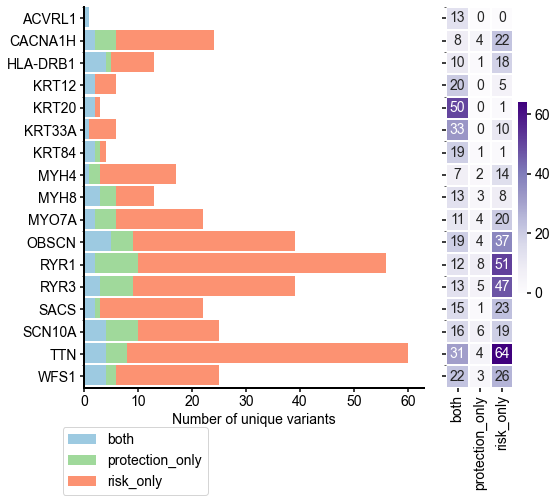

In [10]:
fig, ax = plt.subplots(1,2, figsize=(8, 7), sharey=True, gridspec_kw={"width_ratios": [4,1], "wspace" : 0.1})
ctouse = [sns.color_palette(c, 15).as_hex()[5]  for c in ["Blues", "Greens", "Reds"]]
df.variant_id.plot(kind = 'barh', stacked = True, color=ctouse, width=0.9, ax=ax[0], align='edge')
sns.heatmap(data=df.Sample, annot=df.Sample, cmap="Purples", square=True, ax=ax[1], cbar_kws={"shrink": 0.5}, linewidths=2, linecolor="w")
# Remove Spines
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].legend(loc="lower center", bbox_to_anchor=(0.15, -0.3))

ax[0].set_xlabel("Number of unique variants")
ax[0].set_ylabel("")
ax[1].set_xlabel("")

In [11]:
save_file = "/data5/deepro/ukbiobank/papers/bmi_project/4_characterization/protective/protective_noicd/data/variably_expressive/allelic_effects.pdf"
save_pdf(save_file, fig)